# Image Classification With PIL Image Augmentation

In this colab notebook, I would like to use PIL data augmentation to improve image classification. 

First import all required packages and libraries



# Importing packages

In [0]:
import TensorFlow
import Foundation
import Python
import Time

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let np = Python.import("numpy")  // Make numpy available using np.
let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let os = Python.import("os")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let pilImageOps = Python.import("PIL.ImageOps")
let random = Python.import("random")
let sk = Python.import("skimage")

For this exercise, I had downloaded two class image dataset from Kaggle into my github and used the data. To download the data, please use the following link:<a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Image Database</a>




In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [0]:
print("/bin/ls".shell("-lh"))

We'll now download and unzip the dataset using the `subprocess` library via Python interoperability.

In [4]:
let command = "wget -nv -O- https://github.com/Ayush517/S4TF-Tutorials/raw/master/cats_and_dogs_filtered.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

2020-01-15 03:37:04 URL:https://raw.githubusercontent.com/Ayush517/S4TF-Tutorials/master/cats_and_dogs_filtered.tar.gz [67304034/67304034] -> "-" [1]


0


In [5]:
print("/bin/ls/".shell("-lh"))

total 8.0K
drwxr-x--- 4  501 staff 4.0K Sep 23  2016 cats_and_dogs_filtered
drwxr-xr-x 1 root root  4.0K Jan 13 16:38 sample_data



### Understanding our data

We'll now assign variables with the proper file path for the training and validation sets.

In [0]:
let catTrainList = glob.glob("cats_and_dogs_filtered/train/cats/*.jpg")
let dogTrainList = glob.glob("cats_and_dogs_filtered/train/dogs/*.jpg")
let trainList = glob.glob("cats_and_dogs_filtered/train/**/*.jpg")

let catTestList  = glob.glob("cats_and_dogs_filtered/validation/cats/*.jpg")
let dogTestList  = glob.glob("cats_and_dogs_filtered/validation/dogs/*.jpg")
let testList  = glob.glob("cats_and_dogs_filtered/validation/**/*.jpg")

for i in 0 ..< 5 {
    np.random.shuffle(trainList)
    np.random.shuffle(testList)
}

Let's look at how many cats and dogs images we have in our training and validation directory:

### Visualizing Training images

We can visualize our training images by creating functions to plot images through their paths or tensors, and then plotting a few of them.

In [0]:
func plotImages(_ image: Tensor<Float>) {
    let numpyImage = image.reshaped(to: [150, 150, 3]).makeNumpyArray()
    plt.imshow(numpyImage)
    plt.show()
}

func plotImages(fromPath path: String) {
    let img = pil.Image.open(path)
    let image = np.array(img) * (1.0 / 255)
    plt.imshow(image)
    plt.show()
}

# Data Augmentation

To avoid overfitting and increase training efficiencies, I will use data augmentation techniques using **PIL** **(Python Image Library)**

I will apply image augmentation techniques randomly on an image:

* Rotating the image
* Transposing
* Cropping
* Flipping the image horizontally
* Adding border to image
* Adding noise

In [0]:
func augmentedImage(path: String) -> Tensor<Float> {
    
    var img = pil.Image.open(path)
    
    if random.random() < 0.5 {
        img = img.rotate(45) // Rotate 45 degrees.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.TRANSPOSE) // Transpose.
    }
    
    if random.random() < 0.5 {
        let h = Float(img.size[0])! / 4
        let w = Float(img.size[1])! / 4
        let cropBorder = Int(Python.min(h, w))
        img = pilImageOps.crop(img,  cropBorder) // Crop by half of shorter sides.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.FLIP_LEFT_RIGHT) // Flip.
    }
    
    if random.random() < 0.5 {
        let h = Float(img.size[0])! / 10
        let w = Float(img.size[1])! / 10
        let borderSize = Int(Python.min(h, w))
        img = pilImageOps.expand(img, borderSize) // Add border.
    }
    
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    
    if random.random() < 0.5 {
        image = sk.util.random_noise(image) // Add noise.
    }
    
    image = np.array(image, dtype: np.float32)
    
    let imageTensor = Tensor<Float>(numpy: image)!

    return imageTensor
}

# Data Preparation 

In [0]:
func resizedImage(fromPath: String, augmented: Bool) -> (Tensor<Float>, Int32) {
    var img = pil.Image.open(fromPath)
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    var imageTensor = Tensor<Float>(numpy: image)!
    
    if augmented {
        imageTensor = augmentedImage(path: fromPath)
    }
    
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = Raw.resizeArea(images: imageTensor , size: [150, 150])
    
    let label: Int32 = fromPath.contains("dog.") ? 0 : 1
    
    return (imageTensor, label)
}

func images(fromList: PythonObject, imageCount: Int, augmented: Bool) -> (image: Tensor<Float>, label: Tensor<Int32>) {
    let batchFiles = fromList[0..<imageCount]
    var labels: [Int32] = []
    var x: Tensor<Float>
    var y: Tensor<Int32>

    // Load first image.
    let path = String(batchFiles[0]) ?? ""
    let data = resizedImage(fromPath: path, augmented: augmented)
    x = data.0 
    labels.append(data.1)

    // Load rest of the images.
    var numberOfFilesDone = 1
    for file in batchFiles[1..<imageCount] {
        let path = String(file) ?? ""
        let data = resizedImage(fromPath: path, augmented: augmented)
        let tensor = data.0
        labels.append(data.1)
        x = Tensor(concatenating: [x, tensor], alongAxis: 0)
    }
    y = Tensor<Int32>(labels)
    return (x, y)
}

After defining our generators for images and labels, we will load those images and labels in tensor arrays, thereby creating our `testTensors`.

In [0]:
let testTensors = images(fromList: testList, imageCount: testList.count, augmented: false)
let testImageTensors = testTensors.0
let testLabelTensors = testTensors.1
print(testImageTensors.shape)
print(testLabelTensors.shape)

# Model Creation

I built a model with 4 deep layers. 

In [0]:
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1c = Conv2D<Float>(filterShape: (3, 3, 64, 128), activation: relu)
    var pool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1d = Conv2D<Float>(filterShape: (3, 3, 128, 128), activation: relu)
    var pool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var dropout1a = Dropout<Float>(probability: 0.5)
    var flatten = Flatten<Float>()
    var layer1a = Dense<Float>(inputSize: 6272, outputSize: 512, activation: relu)
    var layer1b = Dense<Float>(inputSize: 512, outputSize: 2, activation: softmax)

    @differentiable
    public func callAsFunction(_ input: Input) -> Output {
        var convolved1 = input.sequenced(through: conv1a, pool1)
        var convolved2 = convolved1.sequenced(through: conv1b, pool2)
        var convolved3 = convolved2.sequenced(through: conv1c, pool3)
        var convolved4 = convolved3.sequenced(through: conv1d, pool4)
        return convolved4.sequenced(through: dropout1a, flatten, layer1a, layer1b)
    }
}

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `softmaxCrossEntropy` as the loss function. We would also like to look at the training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [0]:
let tensor = Tensor<Float>(zeros: [1, 150, 150, 3])
var classifier = Classifier()
var optimizer = Adam(for: classifier)
classifier(tensor).shape

In [0]:
let epochCount = 100
let batchSize = 100

// Extract a batch of size batchSize.
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start + batchSize]
}

In [0]:
var trainingAccuracy: [Float] = []
var validationAccuracy: [Float] = []
var trainingLoss: [Float] = []
var validationLoss: [Float] = []
var epochsRange: [Int] = []

### Train the model

It's time to train our network. 

 We need to apply the random image augmentations every time an image is accessed, so we recreate `trainTensors` in every epoch.

In [0]:


struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    epochsRange.append(epoch)
    var trainStats = Statistics()
    var testStats = Statistics()
    var bEpoch = DispatchTime.now()
    print("PIL based Data Augmentation for epoch \(epoch)")
    let trainTensors = images(fromList: trainList, imageCount: trainList.count, augmented: true)
    let trainImageTensors = trainTensors.0
    let trainLabelTensors = trainTensors.1
    //print("Dataset Creation Completed")
    
    Context.local.learningPhase = .training
    for i in 0..<Int(trainList.count) / batchSize {
        let x = minibatch(in: trainImageTensors, at: i)
        let y = minibatch(in: trainLabelTensors, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0..<Int(testList.count) / batchSize {
        let x = minibatch(in: testImageTensors, at: i)
        let y = minibatch(in: testLabelTensors, at: i)
        // Compute loss on test set.
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }
    
    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    
    trainingAccuracy.append(trainAccuracy)
    validationAccuracy.append(testAccuracy)
    trainingLoss.append(trainStats.totalLoss)
    validationLoss.append(testStats.totalLoss)

    var eEpoch = DispatchTime.now()
    let nanoTime = eEpoch.uptimeNanoseconds - bEpoch.uptimeNanoseconds
    let epochTime = Double(nanoTime) / 1_000_000_000
    
    print("""
          [Epoch \(epoch)] \
          Time Taken: \(epochTime), \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

### Visualizing results of the training

Let us plot accuracy curves to see if data augmentation techniques applied have worked to reduce overfitting problem.

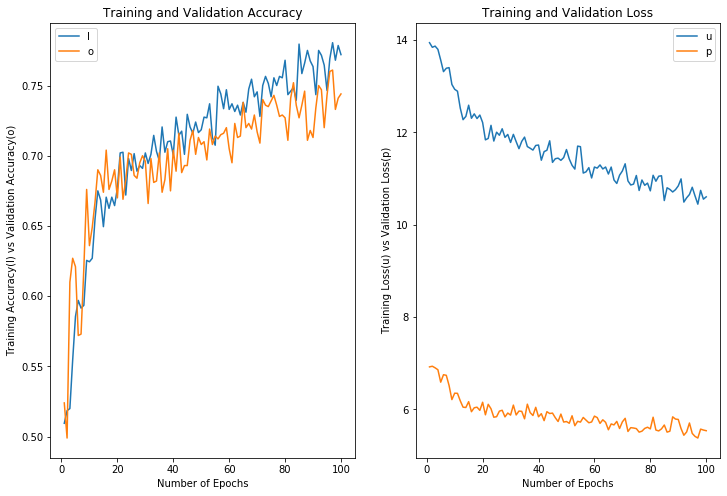

None


In [17]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot(epochsRange, trainingAccuracy)
plt.plot(epochsRange, validationAccuracy)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(epochsRange, trainingLoss)
plt.plot(epochsRange, validationLoss)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()

This looks much better with smaller gap between training and validation accuracies. In summary, data augmentation seems to be working using PIL. 
